In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import sys
sys.path.append("../src")
from utils import eval_on_features_per_store, naive_lag1_per_store

In [2]:
air_reserve = pd.read_csv('../data/raw/air_reserve.csv')
air_store_info = pd.read_csv('../data/raw/air_store_info.csv')
air_visit_data = pd.read_csv('../data/raw/air_visit_data.csv')
date_info = pd.read_csv('../data/raw/date_info.csv')
hpg_reserve = pd.read_csv('../data/raw/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../data/raw/hpg_store_info.csv')
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
hpg_air_store_id_relation = pd.read_csv('../data/raw/store_id_relation.csv')

datasets = {
    'air_reserve': air_reserve,
    'air_store_info': air_store_info,
    'air_visit_data': air_visit_data,
    'date_info': date_info,
    'hpg_reserve': hpg_reserve,
    'hpg_store_info': hpg_store_info,
    'sample_submission': sample_submission,
    'hpg_air_store_id_relation': hpg_air_store_id_relation
}


for name, df in datasets.items():
    for col in df.columns:
        if df[col].dtype == "object" and ("date" in col.lower() or "time" in col.lower()):
            df[col] = pd.to_datetime(df[col], errors="coerce")

air_visit_data

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


In [3]:
# --- Ensure datetime ---
air_visit_data["visit_date"] = pd.to_datetime(air_visit_data["visit_date"])
hpg_reserve["visit_datetime"] = pd.to_datetime(hpg_reserve["visit_datetime"])
date_info["calendar_date"] = pd.to_datetime(date_info["calendar_date"])

# === 1) Per-store daily totals (separate networks) ===
# AIR: actual visitors per air_store_id x date
air_store_daily = (
    air_visit_data
    .groupby(["air_store_id", "visit_date"], as_index=False)["visitors"]
    .sum()
)

# HPG: reservation counts per hpg_store_id x date (no visits dataset exists)
hpg_store_daily = (
    hpg_reserve
    .assign(visit_date=hpg_reserve["visit_datetime"].dt.normalize())  # date only
    .groupby(["hpg_store_id", "visit_date"], as_index=False)["reserve_visitors"]
    .sum()
    .rename(columns={"reserve_visitors": "visitors"})
)

# Optional: add a "source" flag and stack into one long table
air_long = air_store_daily.assign(source="air")
hpg_long = hpg_store_daily.assign(source="hpg")
per_store_daily_long = pd.concat([air_long, hpg_long], ignore_index=True)

# === 2) (Optional) Map HPG stores to AIR store IDs via relation table ===
# Use this if you want everything keyed by air_store_id
# rel: columns ["air_store_id","hpg_store_id"]
hpg_mapped_to_air = (
    hpg_store_daily
    .merge(hpg_air_store_id_relation, on="hpg_store_id", how="inner")
    .drop(columns=["hpg_store_id"])
    .groupby(["air_store_id", "visit_date"], as_index=False)["visitors"]
    .sum()
    .assign(source="hpg_mapped")
)

# Combined per-air_store_id table (AIR visitors + HPG reservations mapped)
per_air_store_combined = pd.concat(
    [air_store_daily.assign(source="air"), hpg_mapped_to_air],
    ignore_index=True
)

# === 3) (Optional) Attach holidays & simple calendar features per store ===
# If you need features, merge on date (applies equally to either table above)
date_feats = (
    date_info[["calendar_date", "holiday_flg"]]
    .rename(columns={"calendar_date": "visit_date"})
)
for df_ in (per_store_daily_long, per_air_store_combined):
    df_.merge(date_feats, on="visit_date", how="left", copy=False)
    if "holiday_flg" in df_.columns:
        df_["holiday_flg"] = df_["holiday_flg"].fillna(0).astype(int)
    else:
        df_["holiday_flg"] = 0

# (Optional) Attach store metadata (genre/area) for AIR stores
per_air_store_combined = per_air_store_combined.merge(
    air_store_info[["air_store_id", "air_genre_name", "air_area_name"]],
    on="air_store_id", how="left"
)

per_air_store_combined

# --- Define cutoff date (second last week of April 2017) ---
cutoff_date = pd.to_datetime("2017-04-22")

# --- Filter per_air_store_combined ---
per_air_store_combined = per_air_store_combined[
    per_air_store_combined["visit_date"] <= cutoff_date
].copy()

per_air_store_combined["holiday_flg"] = per_air_store_combined["holiday_flg"].fillna(0).astype(int)
per_air_store_combined["visit_month"] = per_air_store_combined["visit_date"].dt.month
per_air_store_combined["visit_weekday"] = per_air_store_combined["visit_date"].dt.dayofweek
per_air_store_combined["is_weekend"] = (per_air_store_combined["visit_weekday"] >= 5).astype(int)

per_air_store_combined

,air_store_id,visit_date,visitors,source,holiday_flg,air_genre_name,air_area_name,visit_month,visit_weekday,is_weekend
0,air_00a91d42b08b08d9,2016-07-01,35,air,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,7,4,0
1,air_00a91d42b08b08d9,2016-07-02,9,air,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,7,5,1
2,air_00a91d42b08b08d9,2016-07-04,20,air,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,7,0,0
3,air_00a91d42b08b08d9,2016-07-05,25,air,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,7,1,0
4,air_00a91d42b08b08d9,2016-07-06,29,air,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,7,2,0
...,...,...,...,...,...,...,...,...,...,...
270720,air_fea5dc9594450608,2017-04-08,5,hpg_mapped,0,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,4,5,1
270721,air_fea5dc9594450608,2017-04-15,4,hpg_mapped,0,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,4,5,1
270722,air_fea5dc9594450608,2017-04-18,2,hpg_mapped,0,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,4,1,0
270723,air_fea5dc9594450608,2017-04-21,2,hpg_mapped,0,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,4,4,0


In [4]:
len(per_air_store_combined["air_store_id"].unique())

829

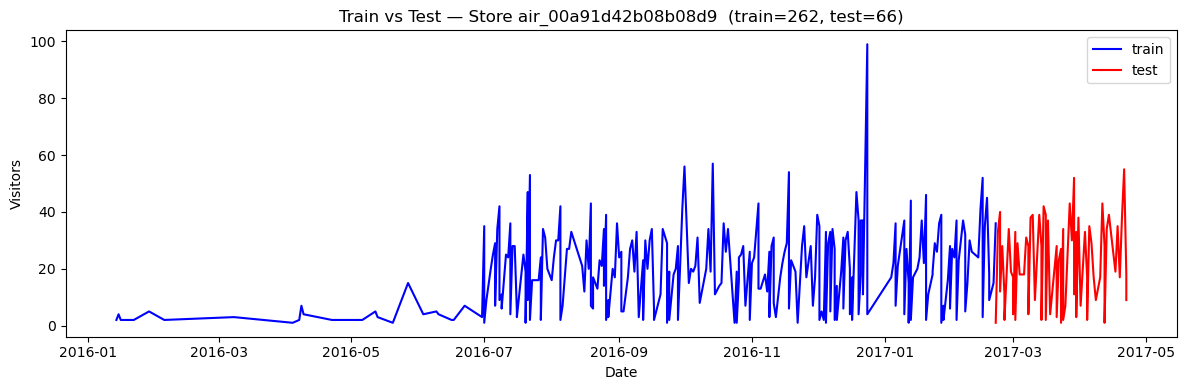

In [5]:
# Ensure per-store chronology
per_air_store_combined = per_air_store_combined.sort_values(
    ["air_store_id", "visit_date"]
).reset_index(drop=True)

def plot_store_split(store_id, frac_train=0.8):
    s = per_air_store_combined.query("air_store_id == @store_id")
    if s.empty:
        print(f"No rows for store {store_id}")
        return
    n_train = int(len(s) * frac_train)
    train, test = s.iloc[:n_train], s.iloc[n_train:]

    plt.figure(figsize=(12,4))
    plt.plot(train["visit_date"], train["visitors"], "b", label="train")
    plt.plot(test["visit_date"],  test["visitors"],  "r", label="test")
    plt.title(f"Train vs Test — Store {store_id}  (train={len(train)}, test={len(test)})")
    plt.xlabel("Date"); plt.ylabel("Visitors"); plt.legend(); plt.tight_layout(); plt.show()

# Example: pick one store
store_id = per_air_store_combined["air_store_id"].iloc[0]
plot_store_split(store_id)

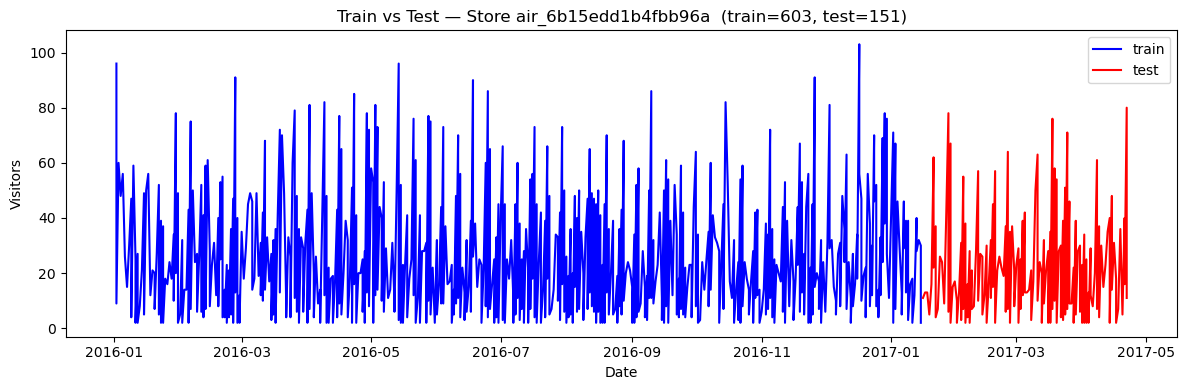

<Figure size 640x480 with 0 Axes>

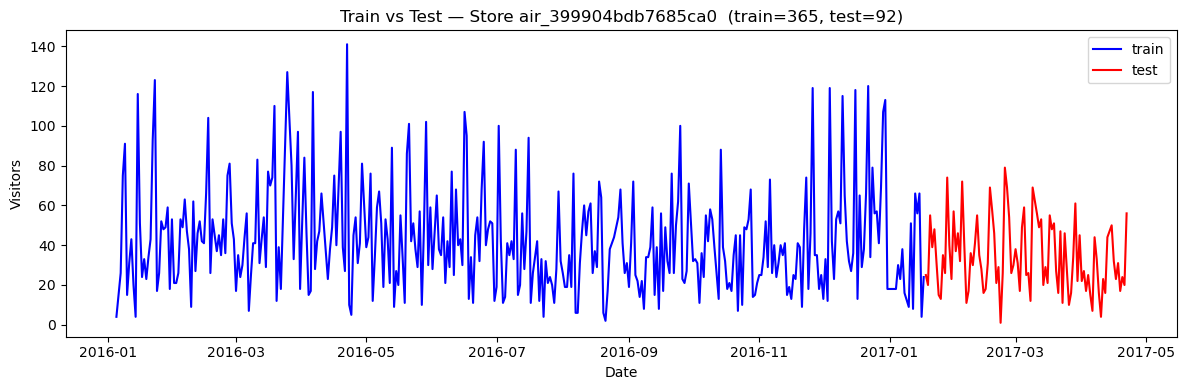

<Figure size 640x480 with 0 Axes>

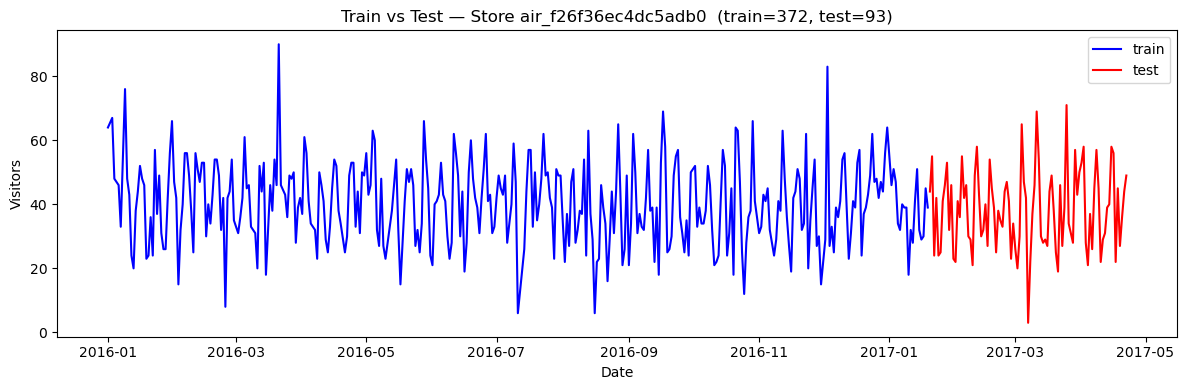

<Figure size 640x480 with 0 Axes>

In [6]:
top_stores = (per_air_store_combined.groupby("air_store_id")["visitors"]
              .sum().sort_values(ascending=False).head(3).index)
for sid in top_stores:
    plot_store_split(sid)
    plt.savefig(f"../reports/figures/per_store_modelling/Train_vs_Test_split_on_Store_{sid}.png")

# Baseline

/Users/mengenliu/Desktop/Portfolio/ds-portfolio/Forecasting-Restaurant-Visitor-Demand-with-Machine-Learning/notebooks/../src/utils.py:118: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_tr_list.append(train["visitors"].shift(1).fillna(method="bfill"))  # trivial for train


Naive lag-1 per-store → R²=-0.178, RMSE=351.32


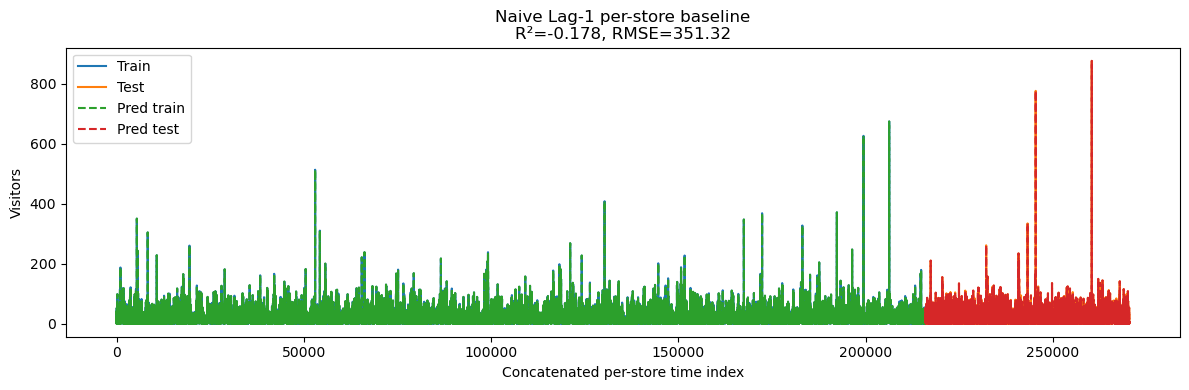

In [7]:
r2, rmse = naive_lag1_per_store(per_air_store_combined)

# Per store lagged features

In [8]:
# Ensure sorted by store & date
per_air_store_combined = per_air_store_combined.sort_values(
    ["air_store_id", "visit_date"]
).reset_index(drop=True)

# Define lag periods
lag_list = [1, 2, 3, 7, 14, 28]

# Add lag features while keeping all existing columns
for lag in lag_list:
    per_air_store_combined[f"visitors_lag{lag}"] = (
        per_air_store_combined.groupby("air_store_id")["visitors"].shift(lag)
    )

per_air_store_combined

,air_store_id,visit_date,visitors,source,holiday_flg,air_genre_name,air_area_name,visit_month,visit_weekday,is_weekend,visitors_lag1,visitors_lag2,visitors_lag3,visitors_lag7,visitors_lag14,visitors_lag28
0,air_00a91d42b08b08d9,2016-01-14,2,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9,2016-01-15,4,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,4,0,2.0,NaN,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9,2016-01-16,2,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,5,1,4.0,2.0,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9,2016-01-22,2,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,4,0,2.0,4.0,2.0,NaN,NaN,NaN
4,air_00a91d42b08b08d9,2016-01-29,5,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,4,0,2.0,2.0,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270393,air_fff68b929994bfbd,2017-04-18,6,air,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,4,1,0,3.0,7.0,7.0,1.0,4.0,2.0
270394,air_fff68b929994bfbd,2017-04-19,2,air,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,4,2,0,6.0,3.0,7.0,6.0,6.0,1.0
270395,air_fff68b929994bfbd,2017-04-20,2,air,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,4,3,0,2.0,6.0,3.0,1.0,6.0,3.0
270396,air_fff68b929994bfbd,2017-04-21,4,air,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,4,4,0,2.0,2.0,6.0,5.0,9.0,8.0


In [9]:
lgbm = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)

X = per_air_store_combined.drop(columns=["visitors", "visit_date", "air_store_id", "source", "air_genre_name", "air_area_name"])
y = per_air_store_combined["visitors"]

X

,holiday_flg,visit_month,visit_weekday,is_weekend,visitors_lag1,visitors_lag2,visitors_lag3,visitors_lag7,visitors_lag14,visitors_lag28
0,0,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,4,0,2.0,NaN,NaN,NaN,NaN,NaN
2,0,1,5,1,4.0,2.0,NaN,NaN,NaN,NaN
3,0,1,4,0,2.0,4.0,2.0,NaN,NaN,NaN
4,0,1,4,0,2.0,2.0,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
270393,0,4,1,0,3.0,7.0,7.0,1.0,4.0,2.0
270394,0,4,2,0,6.0,3.0,7.0,6.0,6.0,1.0
270395,0,4,3,0,2.0,6.0,3.0,1.0,6.0,3.0
270396,0,4,4,0,2.0,2.0,6.0,5.0,9.0,8.0


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Train-set R^2: 0.44
Test-set R^2: 0.40


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


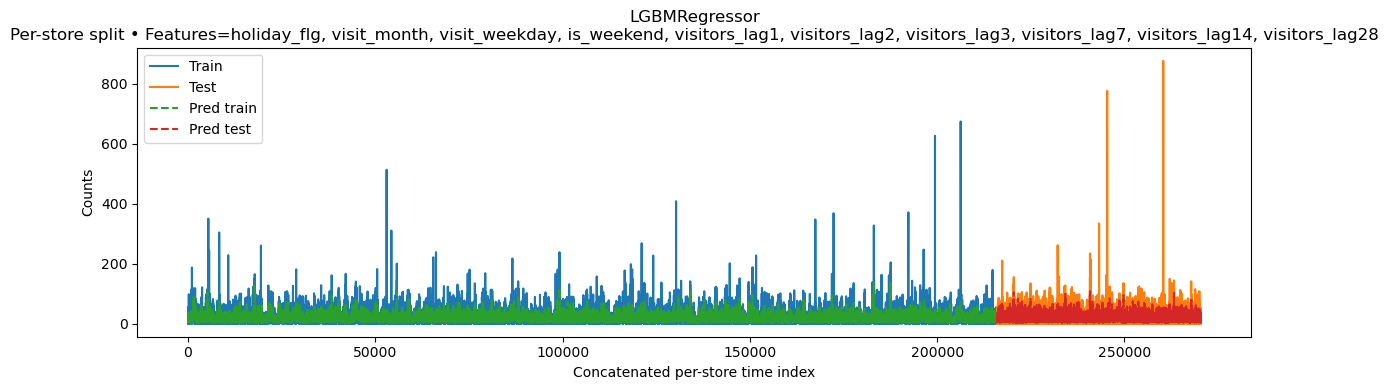

<Figure size 640x480 with 0 Axes>

In [10]:
eval_on_features_per_store(X, y, per_air_store_combined["air_store_id"], lgbm,
                 feat_names=", ".join(X.columns))
plt.savefig("../reports/figures/statistical_modelling/LGBM_Per_Store_Visitor_Count_Feature_Importance.png")

# Moving Average per store

In [11]:
# --- 1) Aggregate global daily totals ---
daily_totals = (
    per_air_store_combined.groupby("visit_date")["visitors"]
      .sum()
      .sort_index()
)

df_global = pd.DataFrame({
    "visit_date": daily_totals.index,
    "visitors_total": daily_totals.values
})

# --- 2) Compute shifted rolling means on the global totals ---
df_global["global_ma7"]  = df_global["visitors_total"].shift(1).rolling(7, min_periods=1).mean()
df_global["global_ma14"] = df_global["visitors_total"].shift(1).rolling(14, min_periods=1).mean()

# --- 3) Merge back into the original per-store dataset ---
per_air_store_combined = per_air_store_combined.merge(
    df_global[["visit_date", "global_ma7", "global_ma14"]],
    on="visit_date", how="left"
)

per_air_store_combined.head()

,air_store_id,visit_date,visitors,source,holiday_flg,air_genre_name,air_area_name,visit_month,visit_weekday,is_weekend,visitors_lag1,visitors_lag2,visitors_lag3,visitors_lag7,visitors_lag14,visitors_lag28,global_ma7,global_ma14
0,air_00a91d42b08b08d9,2016-01-14,2,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,5433.285714,4220.307692
1,air_00a91d42b08b08d9,2016-01-15,4,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,4,0,2.0,NaN,NaN,NaN,NaN,NaN,5567.285714,4305.571429
2,air_00a91d42b08b08d9,2016-01-16,2,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,5,1,4.0,2.0,NaN,NaN,NaN,NaN,5689.285714,4740.500000
3,air_00a91d42b08b08d9,2016-01-22,2,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,4,0,2.0,4.0,2.0,NaN,NaN,NaN,5452.714286,5510.000000
4,air_00a91d42b08b08d9,2016-01-29,5,hpg_mapped,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,1,4,0,2.0,2.0,4.0,NaN,NaN,NaN,5615.714286,5534.214286


(270398, 12)


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Train-set R^2: 0.44
Test-set R^2: 0.40


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


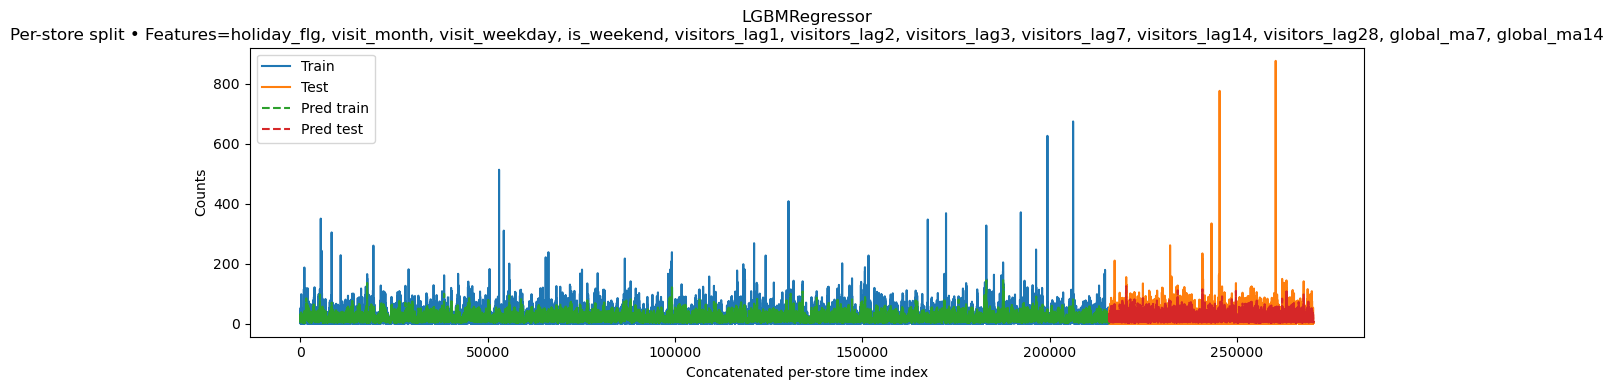

<Figure size 640x480 with 0 Axes>

In [12]:
X = per_air_store_combined.drop(columns=["visitors", "visit_date", "air_store_id", "source", "air_genre_name", "air_area_name"])

print(X.shape)


eval_on_features_per_store(X, y, per_air_store_combined["air_store_id"], lgbm, feat_names=", ".join(X.columns))
plt.savefig("../reports/figures/statistical_modelling/LGBM_Per_Store_Visitor_Count_with_Global_MA_Feature_Importance.png")

# OHE store id

In [13]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
store_ohe = ohe.fit_transform(per_air_store_combined[["air_store_id"]])
store_ohe_df = pd.DataFrame(store_ohe, columns=ohe.get_feature_names_out(["air_store_id"]))

X_ohe = pd.concat([per_air_store_combined.drop(columns=["air_store_id"]).reset_index(drop=True),
                   store_ohe_df.reset_index(drop=True)], axis=1)

X_ohe.columns

Index(['visit_date', 'visitors', 'source', 'holiday_flg', 'air_genre_name',
       'air_area_name', 'visit_month', 'visit_weekday', 'is_weekend',
       'visitors_lag1',
       ...
       'air_store_id_air_fd6aac1043520e83',
       'air_store_id_air_fdc02ec4a3d21ea4',
       'air_store_id_air_fdcfef8bd859f650',
       'air_store_id_air_fe22ef5a9cbef123',
       'air_store_id_air_fe58c074ec1445ea',
       'air_store_id_air_fea5dc9594450608',
       'air_store_id_air_fee8dcf4d619598e',
       'air_store_id_air_fef9ccb3ba0da2f7',
       'air_store_id_air_ffcc2d5087e1b476',
       'air_store_id_air_fff68b929994bfbd'],
      dtype='object', length=846)

(270398, 842)


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Train-set R^2: 1.00
Test-set R^2: 0.97


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


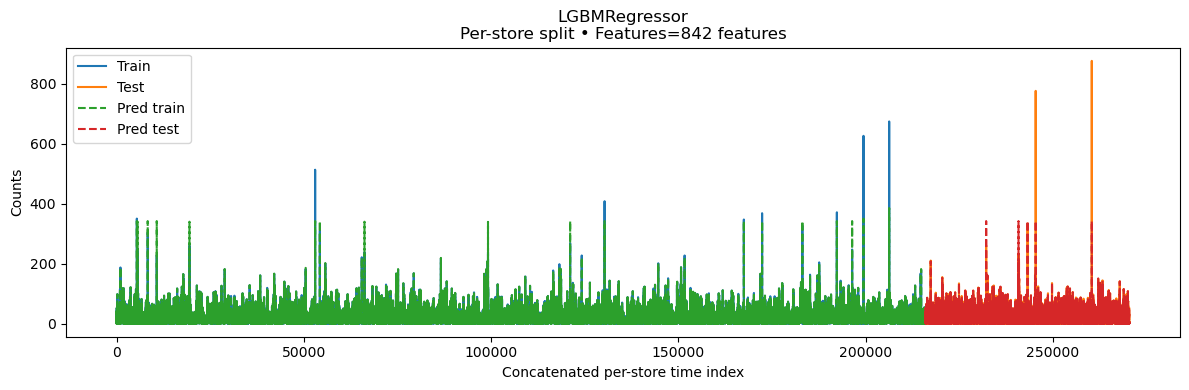

<Figure size 640x480 with 0 Axes>

In [14]:
X = X_ohe.drop(columns=["visit_date", "source", "air_genre_name", "air_area_name"])

print(X.shape)

feat_names = f"{X.shape[1]} features"
eval_on_features_per_store(X, y, per_air_store_combined["air_store_id"], lgbm, feat_names=feat_names)
plt.savefig("../reports/figures/statistical_modelling/LGBM_Per_Store_Visitor_Count_with_OHE_StoreID_Feature_Importance.png")